In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [2]:
img = cv2.imread('med_f.jpeg', cv2.IMREAD_GRAYSCALE)

In [3]:
img = np.hstack([np.zeros((img.shape[0], 1)), img, np.zeros((img.shape[0], 1))])
img = np.vstack([np.zeros((img.shape[1],)), img, np.zeros((img.shape[1],))])

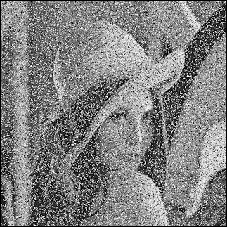

In [4]:
cv2_imshow(img)

In [5]:
mat = np.matrix(img)
with open('input.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%d')

In [6]:
img.shape

(227, 227)

In [10]:
%%writefile task.cu

#include <iostream>
#include <fstream>
#include <stdio.h>
using namespace std;

int* read(int rows, int cols) {
    int* matr = new int[rows*cols];

    ifstream myfile;
    myfile.open ("input.txt");

    for (int i = 0; i < rows*cols; ++i) {
        myfile >> matr[i];
    }
    return matr;
}

void write(int* matr, int rows, int cols) {
    ofstream file;
    file.open("output.txt");
    for (int i = 0; i < rows; i++)
    {
          for (int j = 0; j < cols; j++)
            {
              file<<matr[i*cols+j]<< ' ';
            }
      file<<"\n";
    }
	file.close();
}

//CUDA Kernels

__global__
void median_filter(int* img, int rows, int cols, int n, int m, int* res) {
    
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int buffer[36];
    int temp;
    //printf("Hello world\n");
    if (x<rows-n+1 && y<cols-m+1) {
      int lin_coord = x*(cols - m + 1) + y;
      
          for(int i=-n/2; i<=n/2; ++i) {
              for(int j=-m/2; j<=m/2; ++j) {                    
                  buffer[(i+n/2)*m+j+m/2] = img[(x+(n-1)/2 + i)*cols+y+(m-1)/2+j];                  
          }
      }
      for(int i=0; i<n*m-1; ++i)
        for(int j=1; j<n*m; ++j)
          if(buffer[i]>buffer[j]) {
              temp = buffer[j];
              buffer[j] = buffer[i];
              buffer[i] = temp;
          }

      res[lin_coord] = buffer[n*m/2 + 1];
    }
    
    
}


int main() {
    int rows = 227;
    int cols = 227;
    int* host_img = read(rows, cols);
    int* device_img;
    int* h_res;
    int* d_res;
    cudaMalloc((void**)&device_img, rows*cols*sizeof(int));
    cudaMemcpy(device_img, host_img, rows*cols*sizeof(int), cudaMemcpyHostToDevice);

    cudaMalloc((void**)&d_res, (rows-2)*(cols-2)*sizeof(int));

    h_res = new int[(rows-2)*(cols-2)];

    median_filter<<<dim3(16,16), dim3(25, 34)>>>(device_img, rows, cols, 3, 3, d_res);


    cudaMemcpy(h_res, d_res, (rows-2)*(cols-2)*sizeof(int), cudaMemcpyDeviceToHost);

    write(h_res, rows-2, cols-2);


    cudaFree(d_res);
    cudaFree(device_img);
    delete h_res;
    delete[] host_img;
    //obliterate(img, rows, cols);
    return 0;
}

Overwriting task.cu


In [11]:
!nvcc -arch sm_35 task.cu

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [12]:
!./a.out

In [13]:
with open('output.txt', 'r') as f:
    l = [[int(num) for num in line.split(' ')[:-1]] for line in f]

In [14]:
img = np.array(l)

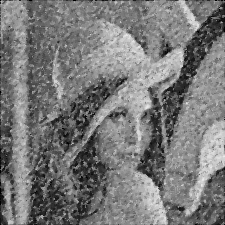

In [15]:
cv2_imshow(img)